alpha1=0.2316, beta1=0.5561
alpha2=0.2445, beta2=2.5271
alpha3=2.6210, beta3=-0.0070
alpha4=-2.3348

Đánh giá mô hình trên TOÀN BỘ DỮ LIỆU:
MAE: 0.1254
MSE: 0.0293
RMSE: 0.1713
R2 Score: 0.1047


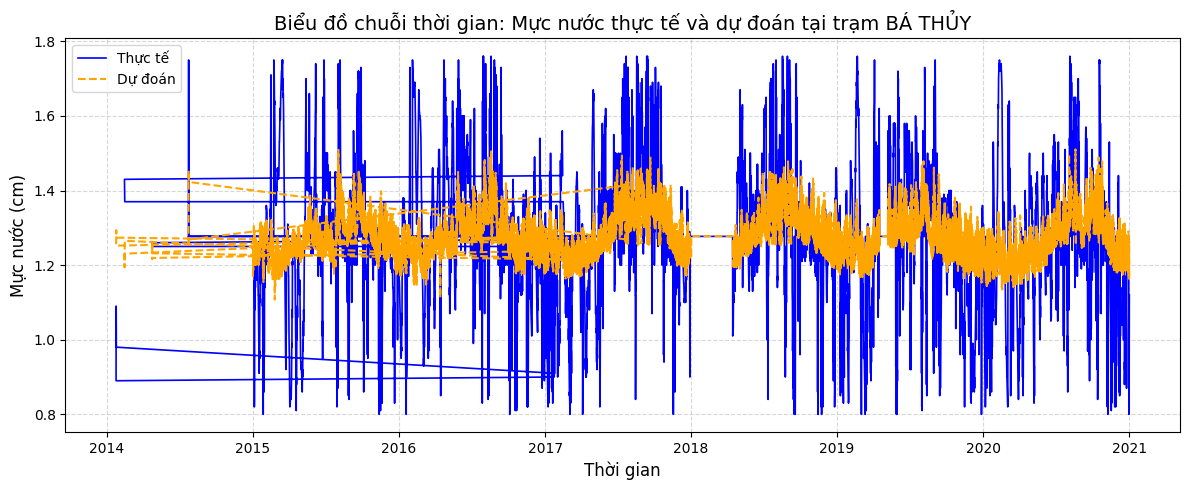

In [19]:
#beta1 # beta2 #beta3 #1(2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import curve_fit

# 1. Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# 2. Cột đầu vào và đầu ra
feature_cols = ['X. QUAN', 'CẦU CẤT', 'CẦU XE', 'AN THỔ', 'LỰC ĐIỀN']
target_col = 'BÁ THUỶ'

df = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# 3. Tạo trễ
def create_lagged_features(data, feature_cols, target_col, n_lags=1):
    df = data.copy()
    for col in feature_cols + [target_col]:
        for lag in range(1, n_lags+1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df.dropna()

df_lagged = create_lagged_features(df, feature_cols, target_col, n_lags=1)

# 4. Chỉ lấy 3 biến đầu với lag=1
X3 = df_lagged[['X. QUAN_lag1', 'CẦU CẤT_lag1', 'CẦU XE_lag1']]
y = df_lagged[target_col]

# 5. Chuẩn hóa
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X3)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 6. Dùng toàn bộ dữ liệu (không chia train/test)
X_full = X_scaled
y_full = y_scaled

# 7. Tách H1, H2, H3 và tránh số mũ gần 0
epsilon = 1e-4
H1, H2, H3 = X_full.T + epsilon

# 8. Định nghĩa mô hình phi tuyến
def nonlinear_model(X, alpha1, beta1, alpha2, beta2, alpha3, beta3, alpha4):
    H1, H2, H3 = X
    return alpha1 * H1**beta1 + alpha2 * H2**beta2 + alpha3 * H3**beta3 + alpha4

# 9. Huấn luyện mô hình
initial_guess = [1, 1, 1, 1, 1, 1, 1]
params, _ = curve_fit(
    nonlinear_model,
    (H1, H2, H3),
    y_full,
    p0=initial_guess,
    maxfev=50000
)

# 10. In hệ số mô hình
alpha1, beta1, alpha2, beta2, alpha3, beta3, alpha4 = params
print(f"alpha1={alpha1:.4f}, beta1={beta1:.4f}")
print(f"alpha2={alpha2:.4f}, beta2={beta2:.4f}")
print(f"alpha3={alpha3:.4f}, beta3={beta3:.4f}")
print(f"alpha4={alpha4:.4f}")

# 11. Dự đoán
y_pred_scaled = nonlinear_model((H1, H2, H3), *params)

# 12. Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_orig = scaler_y.inverse_transform(y_full.reshape(-1, 1)).flatten()

# 13. Đánh giá mô hình
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

mae, mse, rmse, r2 = evaluate_model(y_orig, y_pred)

# 14. In kết quả
print("\nĐánh giá mô hình trên TOÀN BỘ DỮ LIỆU:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# 15. Biểu đồ chuỗi thời gian: Thực tế vs Dự đoán
plt.figure(figsize=(12, 5))
plt.plot(df_lagged.index, y_orig, label='Thực tế', color='blue', linewidth=1.2)
plt.plot(df_lagged.index, y_pred, label='Dự đoán', color='orange', linestyle='--')
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Mực nước (cm)", fontsize=12)
plt.title("Biểu đồ chuỗi thời gian: Mực nước thực tế và dự đoán tại trạm BÁ THỦY", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Phương trình hồi quy:
H = α1·H1 + α2·H2 + α3·H3 + α4
α1 = 0.1525
α2 = 0.0052
α3 = 0.1002
α4 = 0.2152

Đánh giá mô hình trên TOÀN BỘ TẬP DỮ LIỆU:
MAE:  0.1228
MSE:  0.0273
RMSE: 0.1653
R2 Score: 0.1667


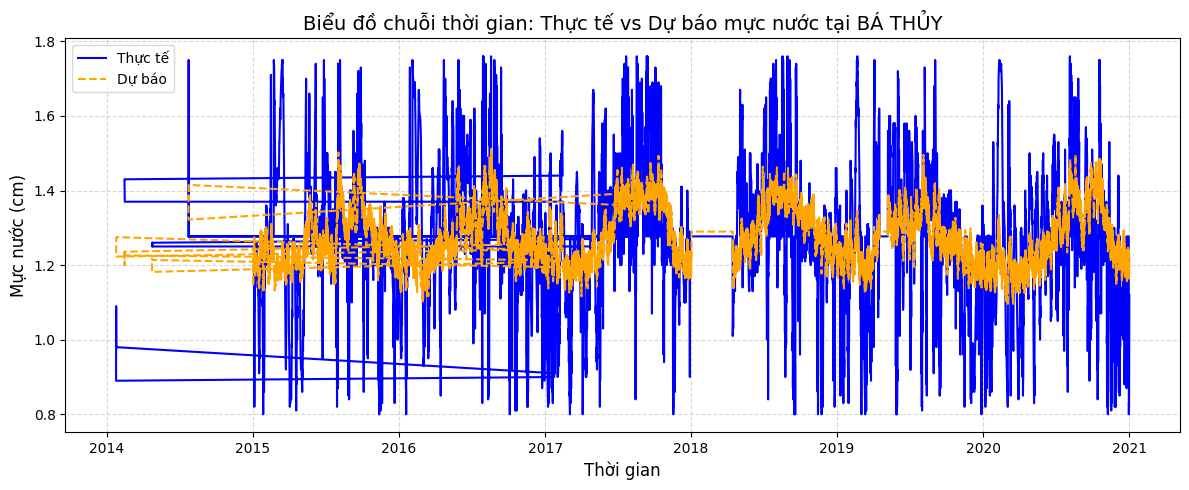

In [17]:
#beta1 = beta2 = beta3 = 1(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import curve_fit

# 1. Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# 2. Chọn cột đầu vào và đầu ra
feature_cols = ['X. QUAN', 'CẦU CẤT', 'CẦU XE', 'AN THỔ', 'LỰC ĐIỀN']
target_col = 'BÁ THUỶ'
df = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# 3. Tạo đặc trưng trễ
def create_lagged_features(data, feature_cols, target_col, n_lags=3):
    df = data.copy()
    for col in feature_cols + [target_col]:
        for lag in range(1, n_lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df.dropna()

df_lagged = create_lagged_features(df, feature_cols, target_col, n_lags=3)

# 4. Tính H1, H2, H3
H1 = df_lagged[[f'{col}_lag1' for col in feature_cols]].mean(axis=1).values
H2 = df_lagged[[f'{col}_lag2' for col in feature_cols]].mean(axis=1).values
H3 = df_lagged[[f'{col}_lag3' for col in feature_cols]].mean(axis=1).values
y = df_lagged[target_col].values

# 5. Chuẩn hóa y
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 6. Ghép H1, H2, H3
X = np.vstack((H1, H2, H3)).T

# 7. Mô hình tuyến tính: y = alpha1*H1 + alpha2*H2 + alpha3*H3 + alpha4
def linear_model(X, alpha1, alpha2, alpha3, alpha4):
    H1, H2, H3 = X
    return alpha1 * H1 + alpha2 * H2 + alpha3 * H3 + alpha4

# 8. Huấn luyện mô hình trên TOÀN BỘ tập
initial_guess = [0.3, 0.3, 0.3, 0.1]
params, _ = curve_fit(linear_model, X.T, y_scaled, p0=initial_guess)

# 9. Dự đoán trên TOÀN BỘ tập
y_pred_scaled = linear_model(X.T, *params)

# 10. Đảo chuẩn hóa
y_orig = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# 11. Đánh giá mô hình
mae = mean_absolute_error(y_orig, y_pred)
mse = mean_squared_error(y_orig, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_orig, y_pred)

# 12. In hệ số
print("\nPhương trình hồi quy:")
print(f"H = α1·H1 + α2·H2 + α3·H3 + α4")
print(f"α1 = {params[0]:.4f}")
print(f"α2 = {params[1]:.4f}")
print(f"α3 = {params[2]:.4f}")
print(f"α4 = {params[3]:.4f}")

# 13. In đánh giá mô hình
print("\nĐánh giá mô hình trên TOÀN BỘ TẬP DỮ LIỆU:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# 14. Biểu đồ chuỗi thời gian: So sánh y thực tế và y dự báo
plt.figure(figsize=(12, 5))
plt.plot(df_lagged.index, y_orig, label='Thực tế', color='blue', linewidth=1.5)
plt.plot(df_lagged.index, y_pred, label='Dự báo', color='orange', linestyle='--')
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Mực nước (cm)", fontsize=12)
plt.title("Biểu đồ chuỗi thời gian: Thực tế vs Dự báo mực nước tại BÁ THỦY", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



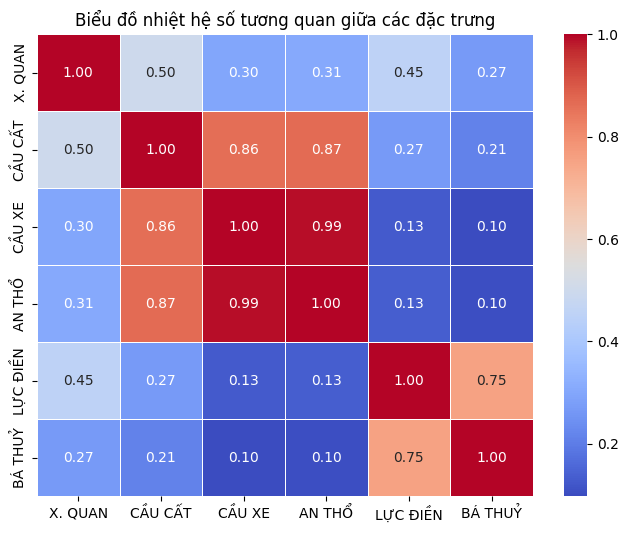

In [ ]:
# Biểu đồ tương quan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử bạn có một DataFrame df chứa các đặc trưng
corr_matrix = df.corr()  # Tính ma trận hệ số tương quan

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Biểu đồ nhiệt hệ số tương quan giữa các đặc trưng")
plt.show()


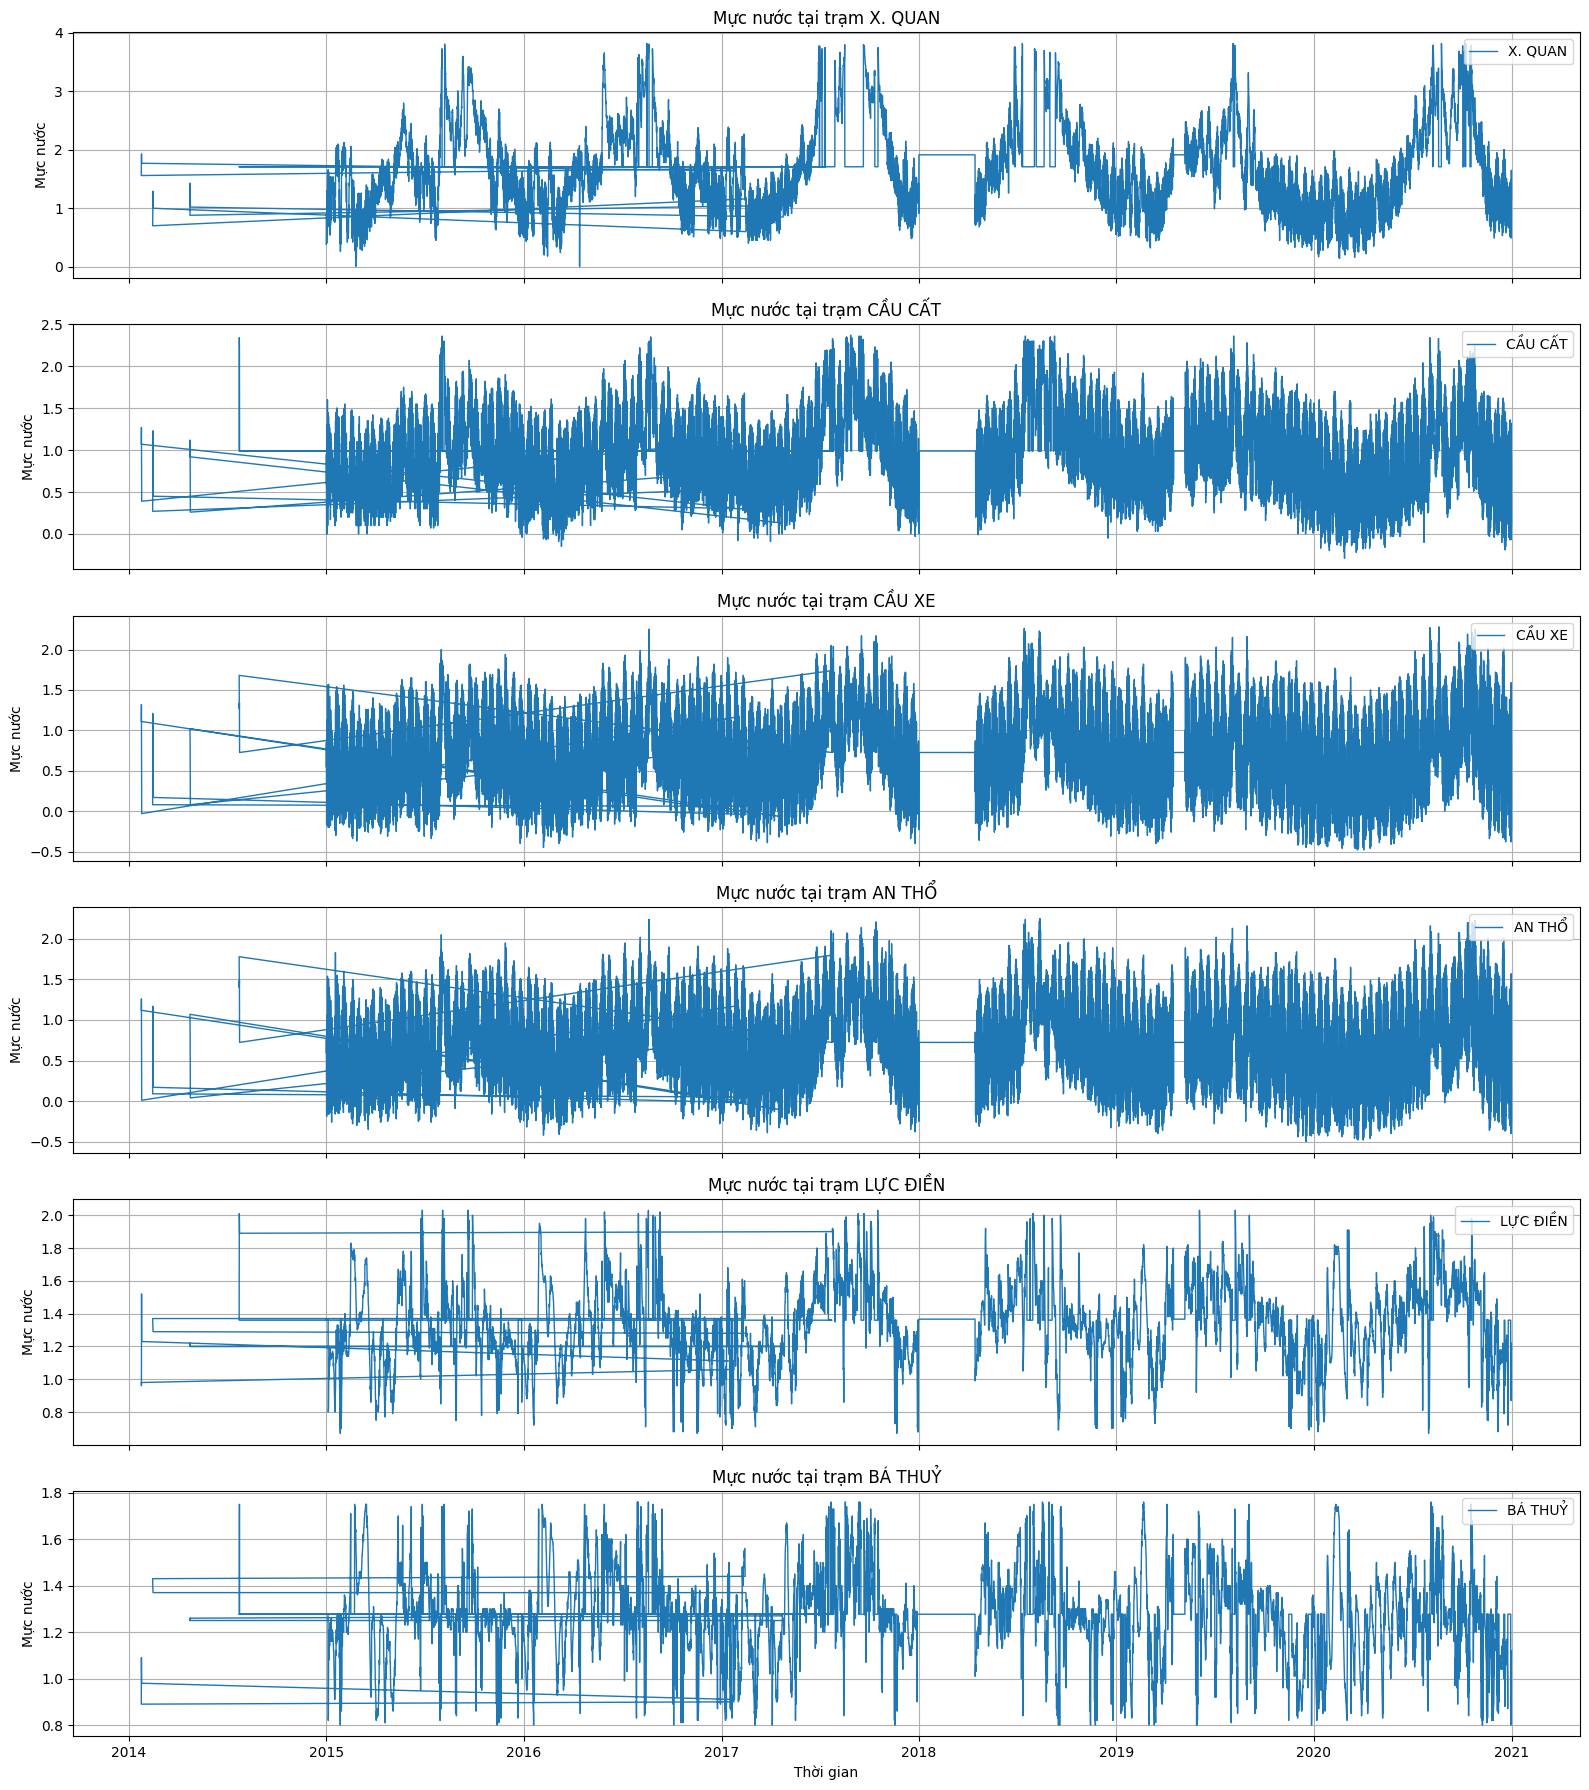

In [ ]:
# Biểu đồ đường
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file Excel
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx", sheet_name="Danh_gia", parse_dates=["Datetime"])

# Chuyển cột thời gian về dạng datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Thiết lập cột thời gian làm index
df.set_index('Datetime', inplace=True)

# Danh sách các trạm thủy văn cần vẽ
stations = ['X. QUAN', 'CẦU CẤT', 'CẦU XE', 'AN THỔ', 'LỰC ĐIỀN', 'BÁ THUỶ']

# Thiết lập số lượng biểu đồ (1 trạm = 1 subplot)
fig, axs = plt.subplots(len(stations), 1, figsize=(16, 18), sharex=True)

# Vẽ từng biểu đồ cho từng trạm
for i, station in enumerate(stations):
    axs[i].plot(df.index, df[station], label=station, linewidth=1)
    axs[i].set_title(f"Mực nước tại trạm {station}")
    axs[i].set_ylabel("Mực nước")
    axs[i].legend(loc="upper right")
    axs[i].grid(True)

plt.xlabel("Thời gian")
plt.tight_layout()
plt.show()


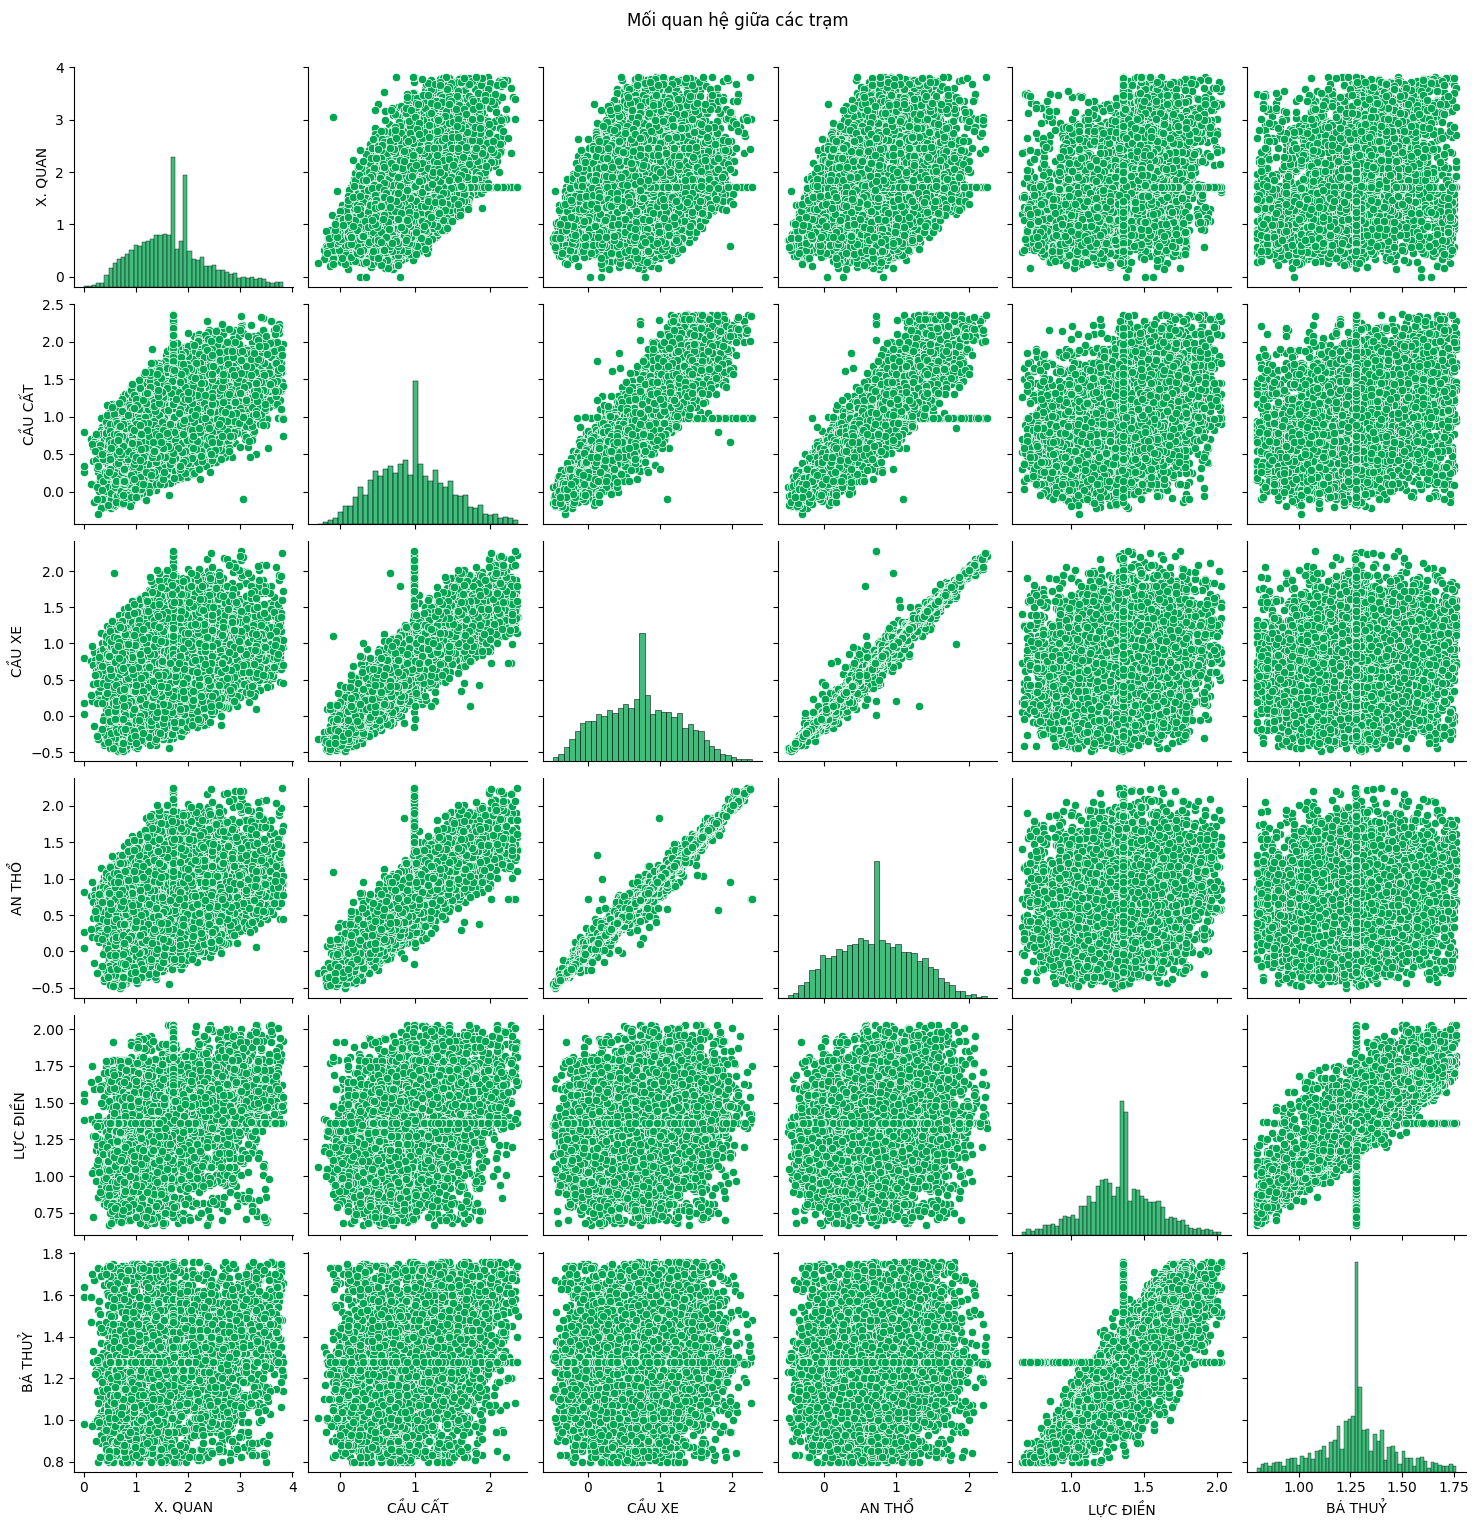

In [ ]:
#biểu đồ tán xạ
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx", sheet_name="Danh_gia", parse_dates=["Datetime"])

# Chọn các cột trạm cần phân tích
stations = ['X. QUAN', 'CẦU CẤT', 'CẦU XE', 'AN THỔ', 'LỰC ĐIỀN', 'BÁ THUỶ']

# Vẽ biểu đồ ma trận tán xạ với màu xanh lá
sns.pairplot(
    df[stations],
    plot_kws={'color': '#00a651'},      # màu điểm trong scatter plot
    diag_kws={'color': '#00a651', 'fill': True}  # màu histogram đường chéo
)

plt.suptitle("Mối quan hệ giữa các trạm", y=1.02)
plt.show()


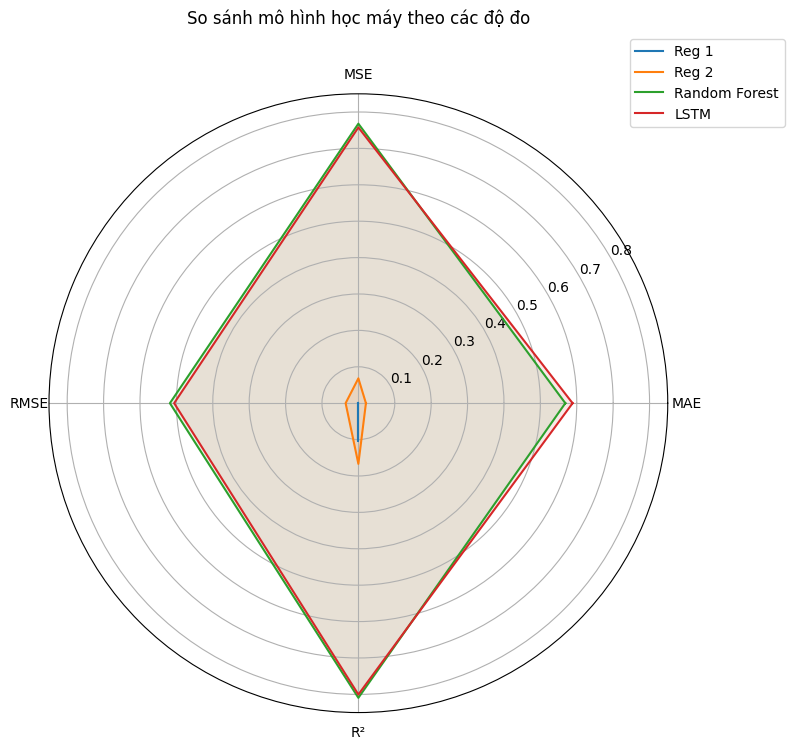

In [ ]:
# Biểu đồ radar
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Tên mô hình và các độ đo
models = ['Reg 1', 'Reg 2', 'Random Forest', 'LSTM']
metrics = ['MAE', 'MSE', 'RMSE', 'R²']

# Dữ liệu (giá trị gốc)
data = [
    [0.1254, 0.0293, 0.1713, 0.1047],  # Reg 1
    [0.1228, 0.0273, 0.1653, 0.1667],  # Reg 2
    [0.0541, 0.0068, 0.0826, 0.8095],  # RF
    [0.0516, 0.0071, 0.0846, 0.8004]   # LSTM
]

# Đảo MAE, MSE, RMSE (càng nhỏ càng tốt)
data_norm = []
for i in range(len(metrics)):
    col = [row[i] for row in data]
    if metrics[i] in ['MAE', 'MSE', 'RMSE']:
        max_val = max(col)
        norm_col = [1 - x / max_val for x in col]
    else:
        norm_col = [x for x in col]  # R² giữ nguyên
    for j in range(len(models)):
        if i == 0:
            data_norm.append([norm_col[j]])
        else:
            data_norm[j].append(norm_col[j])

# Vẽ biểu đồ radar
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model in enumerate(models):
    values = data_norm[i]
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], metrics)
ax.set_title("So sánh mô hình học máy theo các độ đo", y=1.1)
ax.set_rlabel_position(30)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


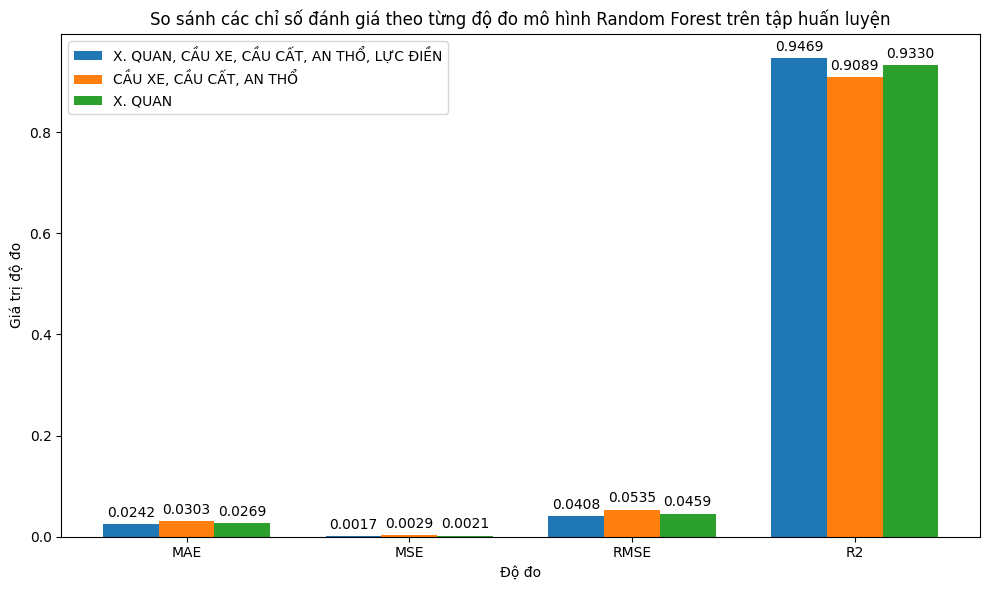

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu từ biểu đồ của bạn
labels = ['MAE', 'MSE', 'RMSE', 'R2']
group1 = [0.0242, 0.0017, 0.0408, 0.9469]  # X. QUAN, CẦU XE, CẦU CẤT, AN THỔ, LỰC ĐIỀN
group2 = [0.0303, 0.0029, 0.0535, 0.9089]  # CẦU XE, CẦU CẤT, AN THỔ
group3 = [0.0269, 0.0021, 0.0459, 0.9330]  # X. QUAN

# Gom lại theo từng độ đo
data = np.array([group1, group2, group3]).T  # shape (4, 3)

x = np.arange(len(labels))  # nhãn trục x
width = 0.25  # độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, CẦU XE, CẦU CẤT, AN THỔ, LỰC ĐIỀN')
rects2 = ax.bar(x, data[:, 1], width, label='CẦU XE, CẦU CẤT, AN THỔ')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

# Nhãn và định dạng
ax.set_xlabel('Độ đo')
ax.set_ylabel('Giá trị độ đo')
ax.set_title('So sánh các chỉ số đánh giá theo từng độ đo mô hình Random Forest trên tập huấn luyện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hiển thị giá trị trên đỉnh cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # khoảng cách phía trên
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


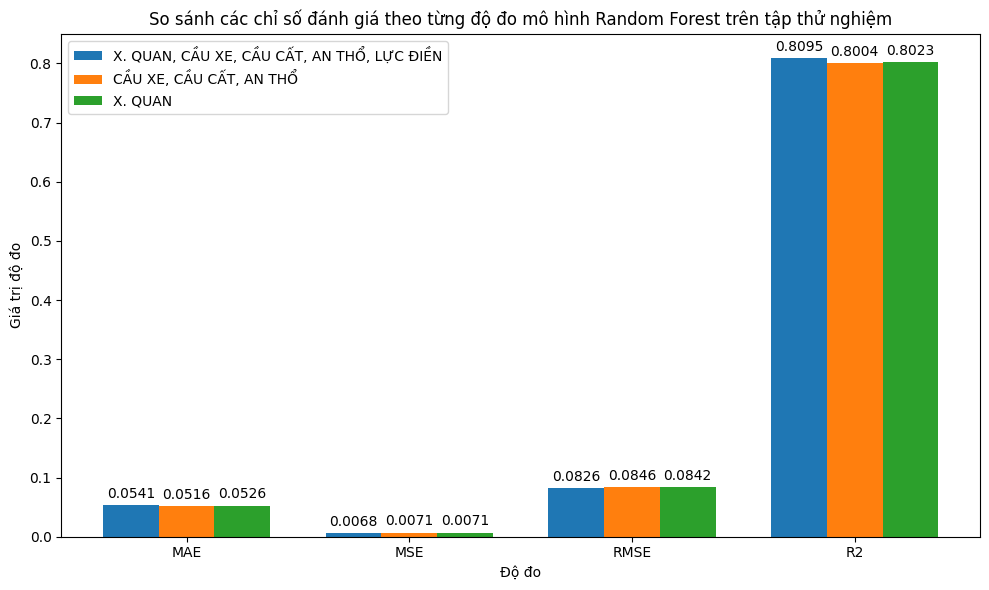

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu độ đo từ biểu đồ tập thử nghiệm
labels = ['MAE', 'MSE', 'RMSE', 'R2']
group1 = [0.0541, 0.0068, 0.0826, 0.8095]  # Tổ hợp 1
group2 = [0.0516, 0.0071, 0.0846, 0.8004]  # Tổ hợp 2
group3 = [0.0526, 0.0071, 0.0842, 0.8023]  # Tổ hợp 3

# Chuyển thành dạng phù hợp cho vẽ cột
data = np.array([group1, group2, group3]).T  # shape (4, 3)

x = np.arange(len(labels))  # MAE, MSE, ...
width = 0.25  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, CẦU XE, CẦU CẤT, AN THỔ, LỰC ĐIỀN')
rects2 = ax.bar(x, data[:, 1], width, label='CẦU XE, CẦU CẤT, AN THỔ')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

# Cài đặt trục và tiêu đề
ax.set_xlabel('Độ đo')
ax.set_ylabel('Giá trị độ đo')
ax.set_title('So sánh các chỉ số đánh giá theo từng độ đo mô hình Random Forest trên tập thử nghiệm')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ghi giá trị lên đầu mỗi cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


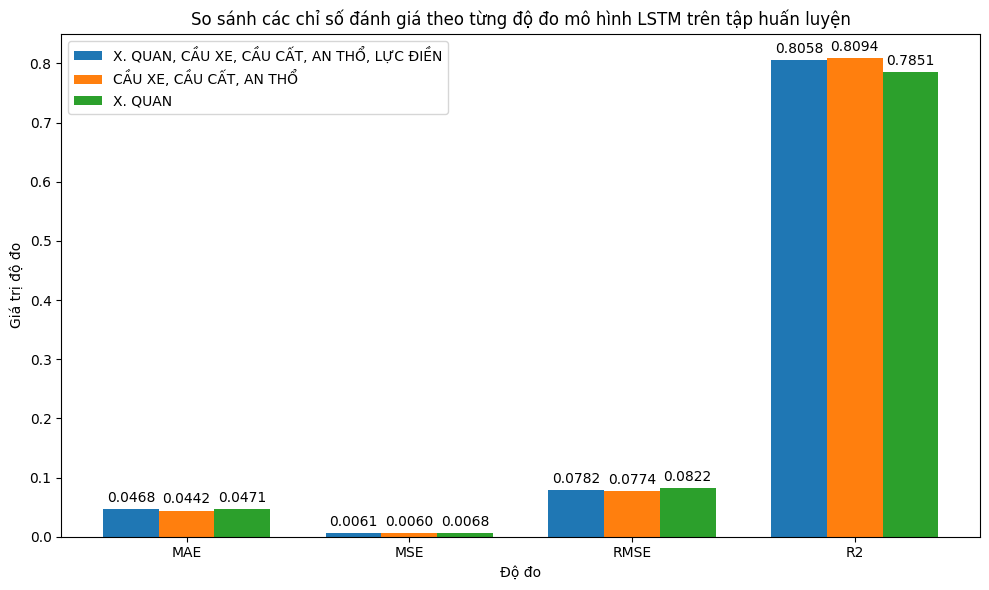

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Nhãn độ đo
labels = ['MAE', 'MSE', 'RMSE', 'R2']

# Dữ liệu từ biểu đồ bạn gửi (theo thứ tự: 4 trạm, 3 trạm, X. QUAN)
group1 = [0.0468, 0.0061, 0.0782, 0.8058]
group2 = [0.0442, 0.0060, 0.0774, 0.8094]
group3 = [0.0471, 0.0068, 0.0822, 0.7851]

data = np.array([group1, group2, group3]).T

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, CẦU XE, CẦU CẤT, AN THỔ, LỰC ĐIỀN')
rects2 = ax.bar(x, data[:, 1], width, label='CẦU XE, CẦU CẤT, AN THỔ')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

ax.set_xlabel('Độ đo')
ax.set_ylabel('Giá trị độ đo')
ax.set_title('So sánh các chỉ số đánh giá theo từng độ đo mô hình LSTM trên tập huấn luyện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ghi nhãn giá trị
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


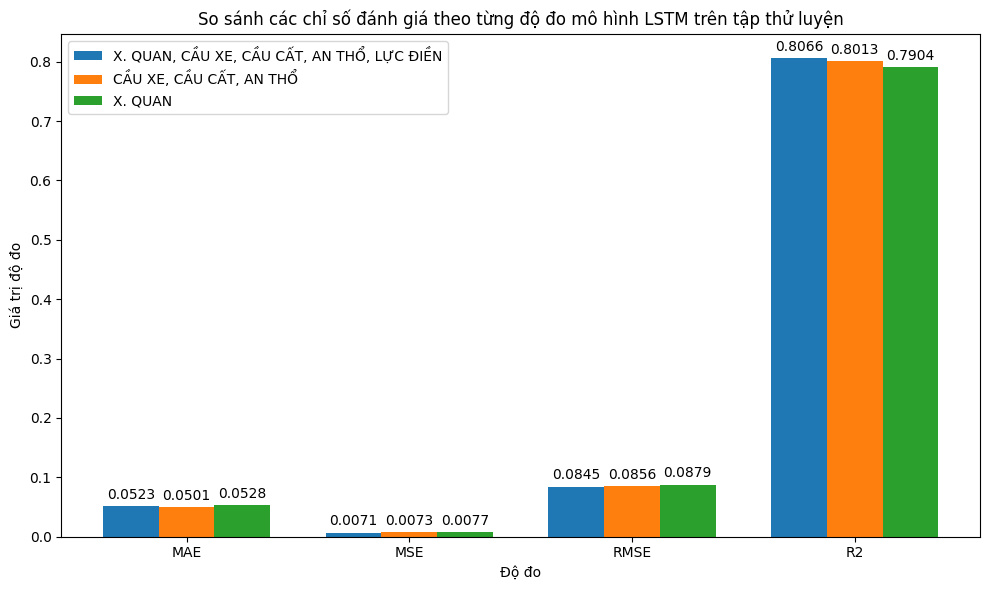

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Nhãn độ đo
labels = ['MAE', 'MSE', 'RMSE', 'R2']

# Dữ liệu từ biểu đồ bạn gửi (theo thứ tự: 4 trạm, 3 trạm, X. QUAN)
group1 = [0.0523, 0.0071, 0.0845, 0.8066]  # 5 trạm
group2 = [0.0501, 0.0073, 0.0856, 0.8013]  # 3 trạm
group3 = [0.0528, 0.0077, 0.0879, 0.7904] 

data = np.array([group1, group2, group3]).T

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, CẦU XE, CẦU CẤT, AN THỔ, LỰC ĐIỀN')
rects2 = ax.bar(x, data[:, 1], width, label='CẦU XE, CẦU CẤT, AN THỔ')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

ax.set_xlabel('Độ đo')
ax.set_ylabel('Giá trị độ đo')
ax.set_title('So sánh các chỉ số đánh giá theo từng độ đo mô hình LSTM trên tập thử luyện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ghi nhãn giá trị
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


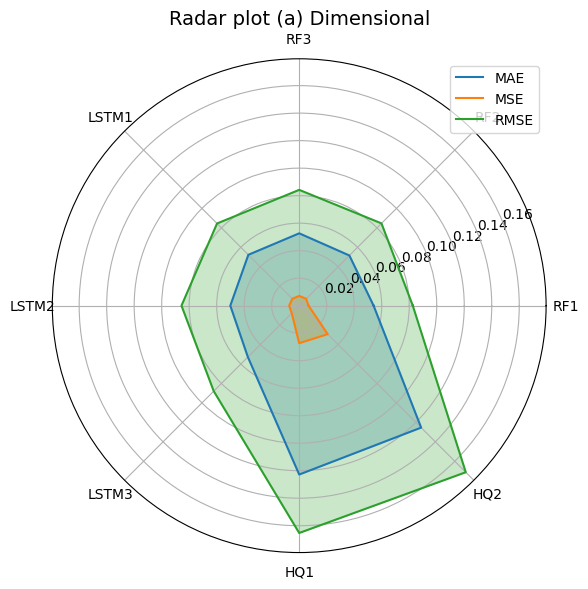

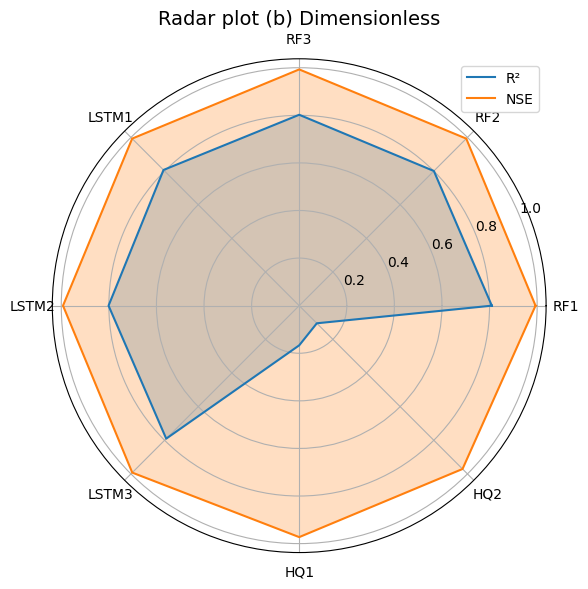

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Tên mô hình
models = ['RF1', 'RF2', 'RF3', 'LSTM1', 'LSTM2', 'LSTM3', 'HQ1', 'HQ2']

# Các độ đo đánh giá
mae = [0.0541, 0.0516, 0.0526, 0.0523, 0.0501, 0.0528, 0.1228, 0.1254]
mse = [0.0068, 0.0071, 0.0071, 0.0071, 0.0073, 0.0077, 0.0273, 0.0293]
rmse = [0.0826, 0.0846, 0.0842, 0.0845, 0.0856, 0.0879, 0.1653, 0.1713]
r2 = [0.8095, 0.8004, 0.8023, 0.8066, 0.8013, 0.7904, 0.1667, 0.1047]

# Hàm vẽ biểu đồ radar
def plot_radar(title, labels, data_series, series_labels):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]  # Khép kín hình

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    for data, label in zip(data_series, series_labels):
        values = data + data[:1]
        ax.plot(angles, values, label=label)
        ax.fill(angles, values, alpha=0.25)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Biểu đồ có thứ nguyên
plot_radar("Radar plot (a) Dimensional", models, [mae, mse, rmse], ["MAE", "MSE", "RMSE"])

# Biểu đồ không có thứ nguyên
plot_radar("Radar plot (b) Dimensionless", models, [r2, [1 - x for x in mse]], ["R²", "NSE"])


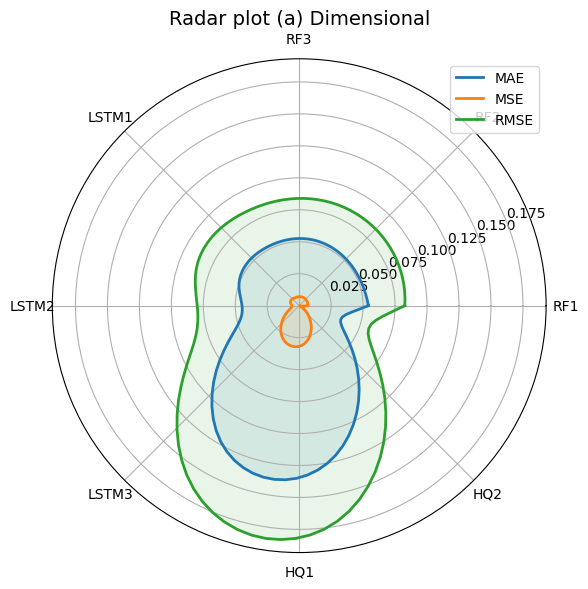

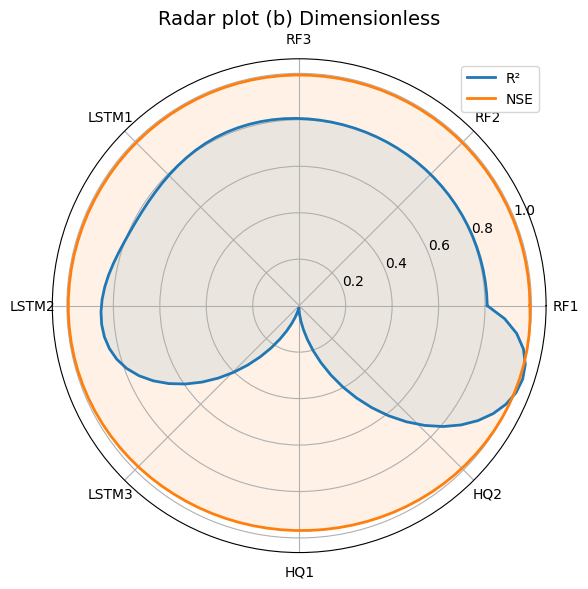

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Tên mô hình
models = ['RF1', 'RF2', 'RF3', 'LSTM1', 'LSTM2', 'LSTM3', 'HQ1', 'HQ2']

# Độ đo đánh giá
mae = [0.0541, 0.0516, 0.0526, 0.0523, 0.0501, 0.0528, 0.1228, 0.1254]
mse = [0.0068, 0.0071, 0.0071, 0.0071, 0.0073, 0.0077, 0.0273, 0.0293]
rmse = [0.0826, 0.0846, 0.0842, 0.0845, 0.0856, 0.0879, 0.1653, 0.1713]
r2 = [0.8095, 0.8004, 0.8023, 0.8066, 0.8013, 0.7904, 0.1667, 0.1047]
nse = [1 - x for x in mse]

def interpolate(values, resolution=100):
    values = values + values[:1]  # khép kín
    x = np.linspace(0, len(values) - 1, len(values))
    f = interp1d(x, values, kind='cubic')
    x_new = np.linspace(0, len(values) - 1, resolution)
    y_new = f(x_new)
    return x_new, y_new

def plot_smooth_radar(title, labels, data_series, series_labels):
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # khép kín

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

    for values, label in zip(data_series, series_labels):
        vals = values + values[:1]
        theta = np.linspace(0, 2 * np.pi, len(vals))
        interp_theta, interp_vals = interpolate(vals)
        interp_theta = np.linspace(0, 2 * np.pi, len(interp_vals))
        ax.plot(interp_theta, interp_vals, label=label, linewidth=2)
        ax.fill(interp_theta, interp_vals, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# 🔹 Radar plot (a): Có thứ nguyên
plot_smooth_radar("Radar plot (a) Dimensional", models, [mae, mse, rmse], ["MAE", "MSE", "RMSE"])

# 🔹 Radar plot (b): Không có thứ nguyên
plot_smooth_radar("Radar plot (b) Dimensionless", models, [r2, nse], ["R²", "NSE"])


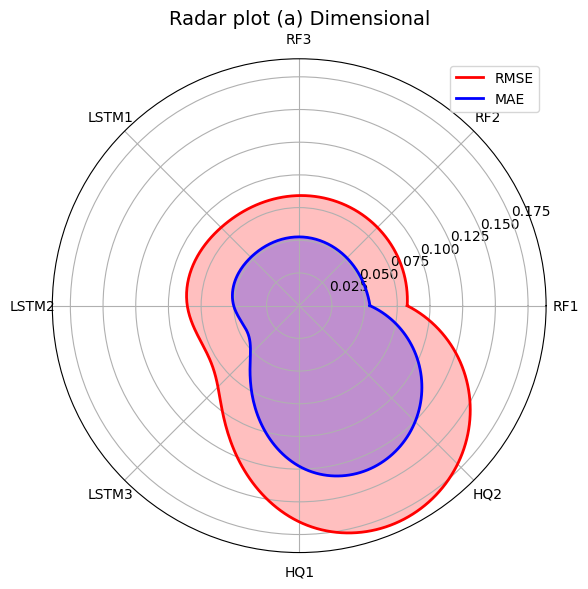

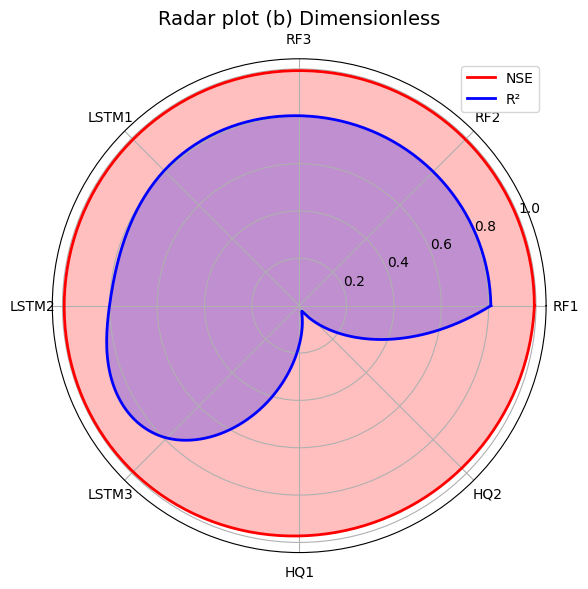

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Tên mô hình
models = ['RF1', 'RF2', 'RF3', 'LSTM1', 'LSTM2', 'LSTM3', 'HQ1', 'HQ2']
N = len(models)

# Dữ liệu
mae = [0.0541, 0.0516, 0.0526, 0.0523, 0.0501, 0.0528, 0.1228, 0.1254]
rmse = [0.0826, 0.0846, 0.0842, 0.0845, 0.0856, 0.0879, 0.1653, 0.1713]
mse = [0.0068, 0.0071, 0.0071, 0.0071, 0.0073, 0.0077, 0.0273, 0.0293]
r2 = [0.8095, 0.8004, 0.8023, 0.8066, 0.8013, 0.7904, 0.1667, 0.1047]
nse = [1 - x for x in mse]

# Góc cho các trục
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

def interpolate(values, kind='cubic', resolution=300):
    values += values[:1]
    theta = np.linspace(0, 2 * np.pi, len(values))
    f = interp1d(theta, values, kind=kind)
    theta_new = np.linspace(0, 2 * np.pi, resolution)
    values_new = f(theta_new)
    return theta_new, values_new

def plot_radar_smooth(title, labels, data_list, data_labels, colors):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    
    for values, label, color in zip(data_list, data_labels, colors):
        theta_new, values_new = interpolate(values.copy())
        ax.plot(theta_new, values_new, label=label, color=color, linewidth=2)
        ax.fill(theta_new, values_new, color=color, alpha=0.25)
    
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# 🔸 Radar (a): Có thứ nguyên
plot_radar_smooth("Radar plot (a) Dimensional", models, [rmse, mae], ["RMSE", "MAE"], ['red', 'blue'])

# 🔹 Radar (b): Không thứ nguyên
plot_radar_smooth("Radar plot (b) Dimensionless", models, [nse, r2], ["NSE", "R²"], ['red', 'blue'])
